This notebook contains code for preprocessing the FANTOM CAGE data to correct for poly-T biasbefore training

In [ ]:
import pandas as pd
plus_file_short = pd.read_table('../resources/polyT_plus_all2.bed.gz', sep='\t')
minus_file_short = pd.read_csv('../resources/polyT_minus_all2.bed.gz', sep='\t')
minus_file_short

,polyA,length,chr,start,end,polyA_motif
0,1.0,2,chr1,10001,10003,2A
1,1.0,2,chr1,10007,10009,2A
2,1.0,2,chr1,10013,10015,2A
3,1.0,2,chr1,10019,10021,2A
4,1.0,2,chr1,10025,10027,2A
...,...,...,...,...,...,...
579600471,1.0,1,chrY,56887880,56887881,1A
579600472,1.0,1,chrY,56887884,56887885,1A
579600473,1.0,1,chrY,56887887,56887888,1A
579600474,1.0,1,chrY,56887890,56887891,1A


In [ ]:
import numpy as np
import pyBigWig
import tabix
from selene_sdk.targets import Target

class GenomicSignalFeatures(Target):
    """
    #Accept a list of cooler files as input.
    """
    def __init__(self, input_paths, features, shape, blacklists=None, blacklists_indices=None):
        """
        Constructs a new `GenomicFeatures` object.
        """
        self.input_paths = input_paths
        self.initialized = False
        self.blacklists = blacklists
        self.blacklists_indices = blacklists_indices

            
        self.n_features = len(features)
        self.feature_index_dict = dict(
            [(feat, index) for index, feat in enumerate(features)])
        self.shape = (len(input_paths), *shape)

    def get_feature_data(self, chrom, start, end, nan_as_zero=True):
        if not self.initialized:
            self.data = [pyBigWig.open(path) for path in self.input_paths]
            if self.blacklists is not None:
                self.blacklists = [tabix.open(blacklist)  for blacklist in self.blacklists]
            self.initialized=True
            
        wigmat = np.vstack([c.values(chrom, start, end, numpy=True)
                           for c in self.data])
        
        if self.blacklists is not None:
            for blacklist, blacklist_indices in zip(self.blacklists, self.blacklists_indices):
                for _, s, e in blacklist.query(chrom, start, end):
                    wigmat[blacklist_indices, np.fmax(int(s)-start,0): int(e)-start] = 0
                

        if nan_as_zero:
            wigmat[np.isnan(wigmat)]=0
        return wigmat
    
tfeature= GenomicSignalFeatures(["../resources/agg.plus.bw.bedgraph.bw",
                                "../resources/agg.minus.bw.bedgraph.bw",
                                "../resources/agg.encodecage.plus.v2.bedgraph.bw",
                                "../resources/agg.encodecage.minus.v2.bedgraph.bw"],
                               ['cage_plus', 'cage_minus','ecage_plus', 'ecage_minus'],
                               (100000,),
                               )


In [ ]:


region = 50

tss_signals = []
tss_signals_control = []

tss_signals_encode = []
tss_signals_encode_control = []
for motif_len in range(4, 51):
    print(motif_len)
    tss_signal_sum = 0
    tss_signal_sum_control = 0
    tss_signal_sum_encode = 0
    tss_signal_sum_encode_control = 0
    coords1 = plus_file_short.loc[plus_file_short['length'] == motif_len,:]
    for i in coords1.index:
        signals = tfeature.get_feature_data(coords1['chr'][i], 
                                                coords1['end'][i]-region, 
                                                coords1['end'][i]+region)
        tss_signal_sum += signals[0]
        tss_signal_sum_control += signals[1]
        tss_signal_sum_encode += signals[2]
        tss_signal_sum_encode_control += signals[3]
    
    coords2 = minus_file_short.loc[minus_file_short['length'] == motif_len,:]
    for i in coords2.index:
        signals = tfeature.get_feature_data(coords2['chr'][i], 
                                                coords2['start'][i]-region, 
                                                coords2['start'][i]+region)[:,::-1]
        tss_signal_sum += signals[1]
        tss_signal_sum_control += signals[0]
        tss_signal_sum_encode += signals[3]
        tss_signal_sum_encode_control += signals[2]
        
    tss_signals.append((tss_signal_sum)/(coords1.shape[0]+coords2.shape[0]))
    tss_signals_control.append((tss_signal_sum_control)/(coords1.shape[0]+coords2.shape[0]))
    tss_signals_encode.append((tss_signal_sum_encode)/(coords1.shape[0]+coords2.shape[0]))
    tss_signals_encode_control.append((tss_signal_sum_encode_control)/(coords1.shape[0]+coords2.shape[0]))



4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50


In [ ]:
import torch
torch.save({'tss_signals':tss_signals, 'tss_signals_control':tss_signals_control, 
           'tss_signals_encode': tss_signals_encode, 'tss_signals_encode_control': tss_signals_encode_control}, 
           '../data/filtert.pth')

In [ ]:
import torch
filtert = torch.load('../data/filtert.pth')

In [ ]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


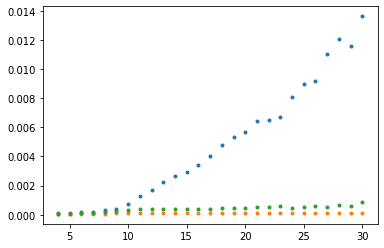

In [ ]:
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline
plt.plot(np.arange(4, 31), np.array(filtert['tss_signals']).max(axis=1)[:27],'.')
plt.plot(np.arange(4, 31), np.array(filtert['tss_signals_control']).max(axis=1)[:27],'.')
plt.plot(np.arange(4, 31), np.array(filtert['tss_signals_encode']).max(axis=1)[:27]*0.61357,'.')


In [ ]:
import pandas as pd
plotdata = pd.DataFrame(dict(signal = np.concatenate([np.array(filtert['tss_signals']).max(axis=1)[:27],
                np.array(filtert['tss_signals_control']).max(axis=1)[:27],
                np.array(filtert['tss_signals_encode']).max(axis=1)[:27]*0.61357,
                 np.array(filtert['tss_signals_encode_control']).max(axis=1)[:27]*0.61357]),
            type =  np.concatenate([np.repeat('FANTOM CAGE +', 27), np.repeat('FANTOM CAGE -', 27),
                                    np.repeat('ENCODE CAGE +', 27), np.repeat('ENCODE CAGE -', 27)]),
           nt = np.tile(np.arange(4,31), 4)
                       ))

In [ ]:
%%R
require(scales)
theme_Publication <- function(base_size=14, base_family="helvetica") {
      library(grid)
      library(ggthemes)
      (theme_foundation(base_size=base_size, base_family=base_family)
       + theme(plot.title = element_text(face = "bold",
                                         size = rel(1.2), hjust = 0.5),
               text = element_text(),
               panel.background = element_rect(colour = NA),
               plot.background = element_rect(colour = NA),
               panel.border = element_rect(colour = NA),
               axis.title = element_text(face = "bold",size = rel(1)),
               axis.title.y = element_text(angle=90,vjust =2),
               axis.title.x = element_text(vjust = -0.2),
               axis.text = element_text(), 
               axis.line = element_line(colour="black"),
               axis.ticks = element_line(),
               panel.grid.major = element_blank(),
               panel.grid.minor = element_blank(),
               legend.key = element_rect(colour = NA),
               legend.position = "bottom",
               legend.direction = "horizontal",
               legend.key.size= unit(0.2, "cm"),
               legend.margin = unit(0, "cm"),
               legend.title = element_text(face="italic"),
               plot.margin=unit(c(10,5,5,5),"mm"),
               strip.background=element_rect(colour="#f0f0f0",fill="#f0f0f0"),
               strip.text = element_text(face="bold")
          ))
      
}
scale_fill_Publication <- function(...){
      discrete_scale("fill","Publication",manual_pal(values = c("#386cb0","#fdb462","#7fc97f","#ef3b2c","#662506","#a6cee3","#fb9a99","#984ea3","#ffff33")), ...)

}
scale_colour_Publication <- function(...){
      discrete_scale("colour","Publication",manual_pal(values = c("#386cb0","#fdb462","#7fc97f","#ef3b2c","#662506","#a6cee3","#fb9a99","#984ea3","#ffff33")), ...)

}

R[write to console]: Saving 5 x 4 in image



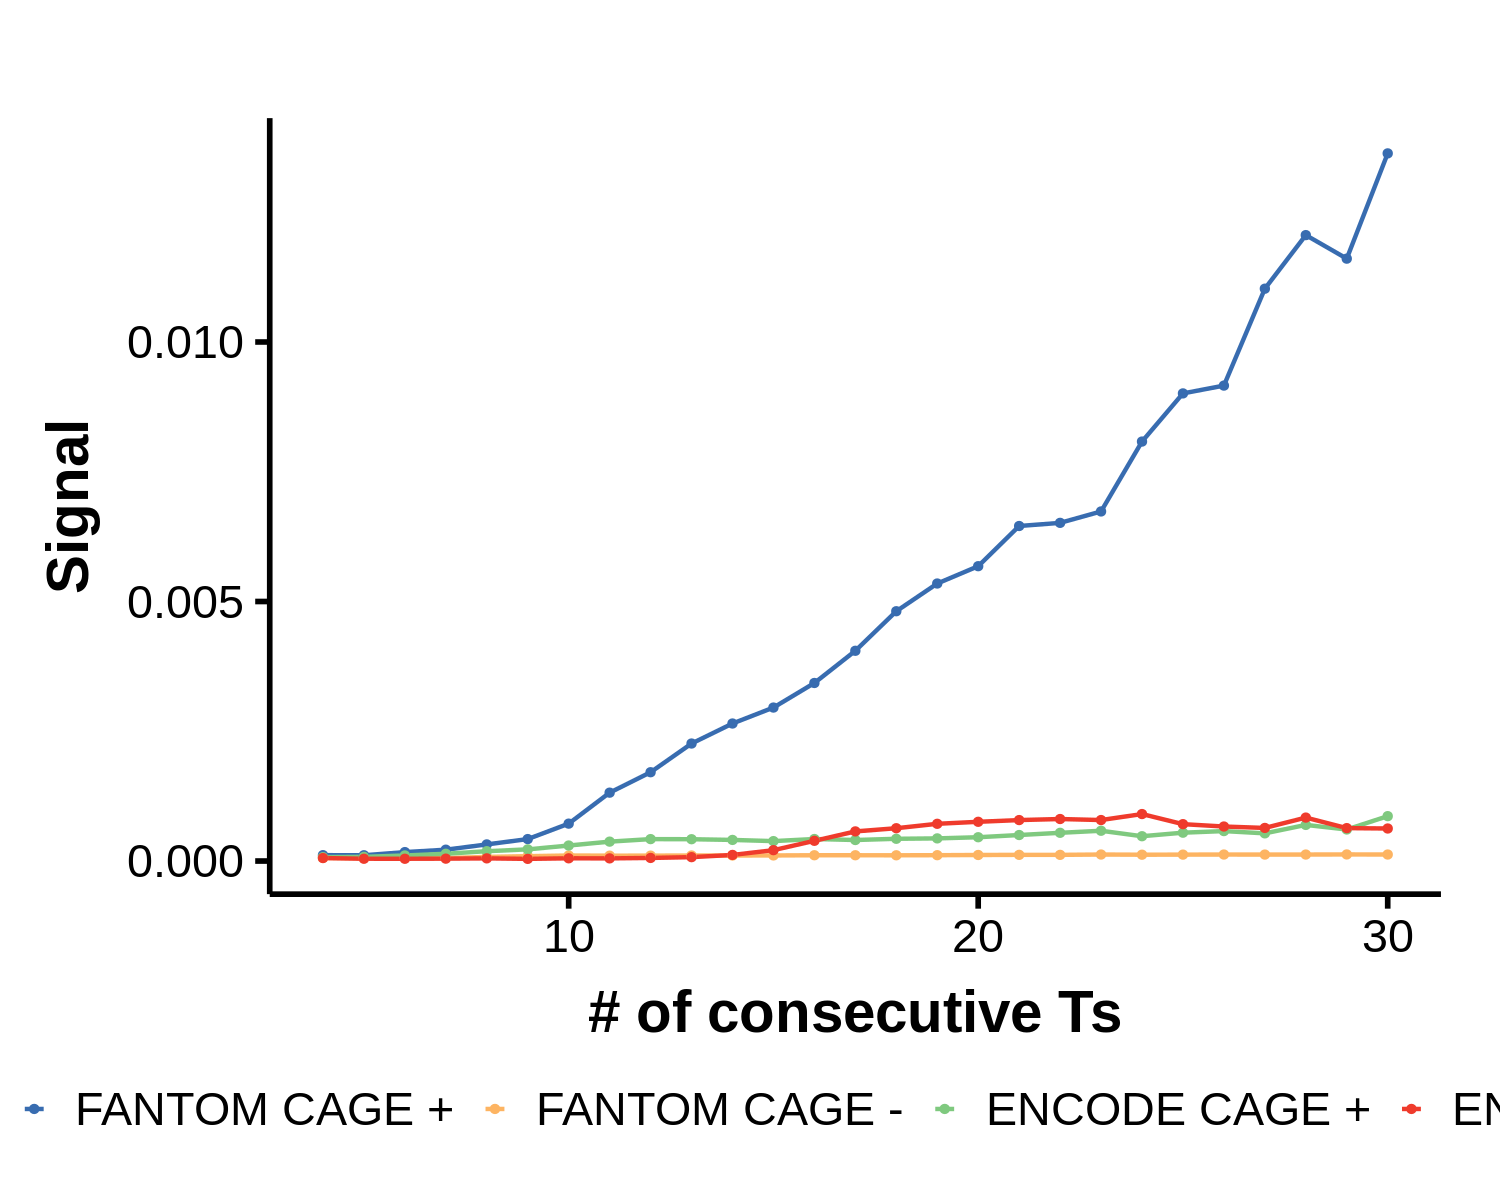

In [ ]:
%%R -i plotdata  -w 5 -h 4 --units in -r 300
require(ggplot2)
plotdata$type = factor(plotdata$type, levels=c('FANTOM CAGE +', 'FANTOM CAGE -',
                                        'ENCODE CAGE +', 'ENCODE CAGE -'))
p= ggplot(plotdata)+geom_line(aes(x=nt, y=signal, color=type), size=I(0.5))+
    geom_point(aes(x=nt, y=signal, color=type), size=I(0.5))+ ylab('Signal')+ xlab('# of consecutive Ts')+
    theme_Publication()+scale_colour_Publication()
ggsave('../figures/filtert.pdf', device=cairo_pdf)
p

In [ ]:
import pandas as pd
plotdata = pd.DataFrame(dict(signal = np.concatenate([filtert['tss_signals'][10-4],
                filtert['tss_signals'][20-4],
                filtert['tss_signals'][30-4]]),
            pos = np.tile(np.arange(-50,50), 3),
           nt = np.concatenate([np.repeat([10], 100), np.repeat([20], 100), np.repeat([30], 100)])))

R[write to console]: Saving 5 x 4 in image



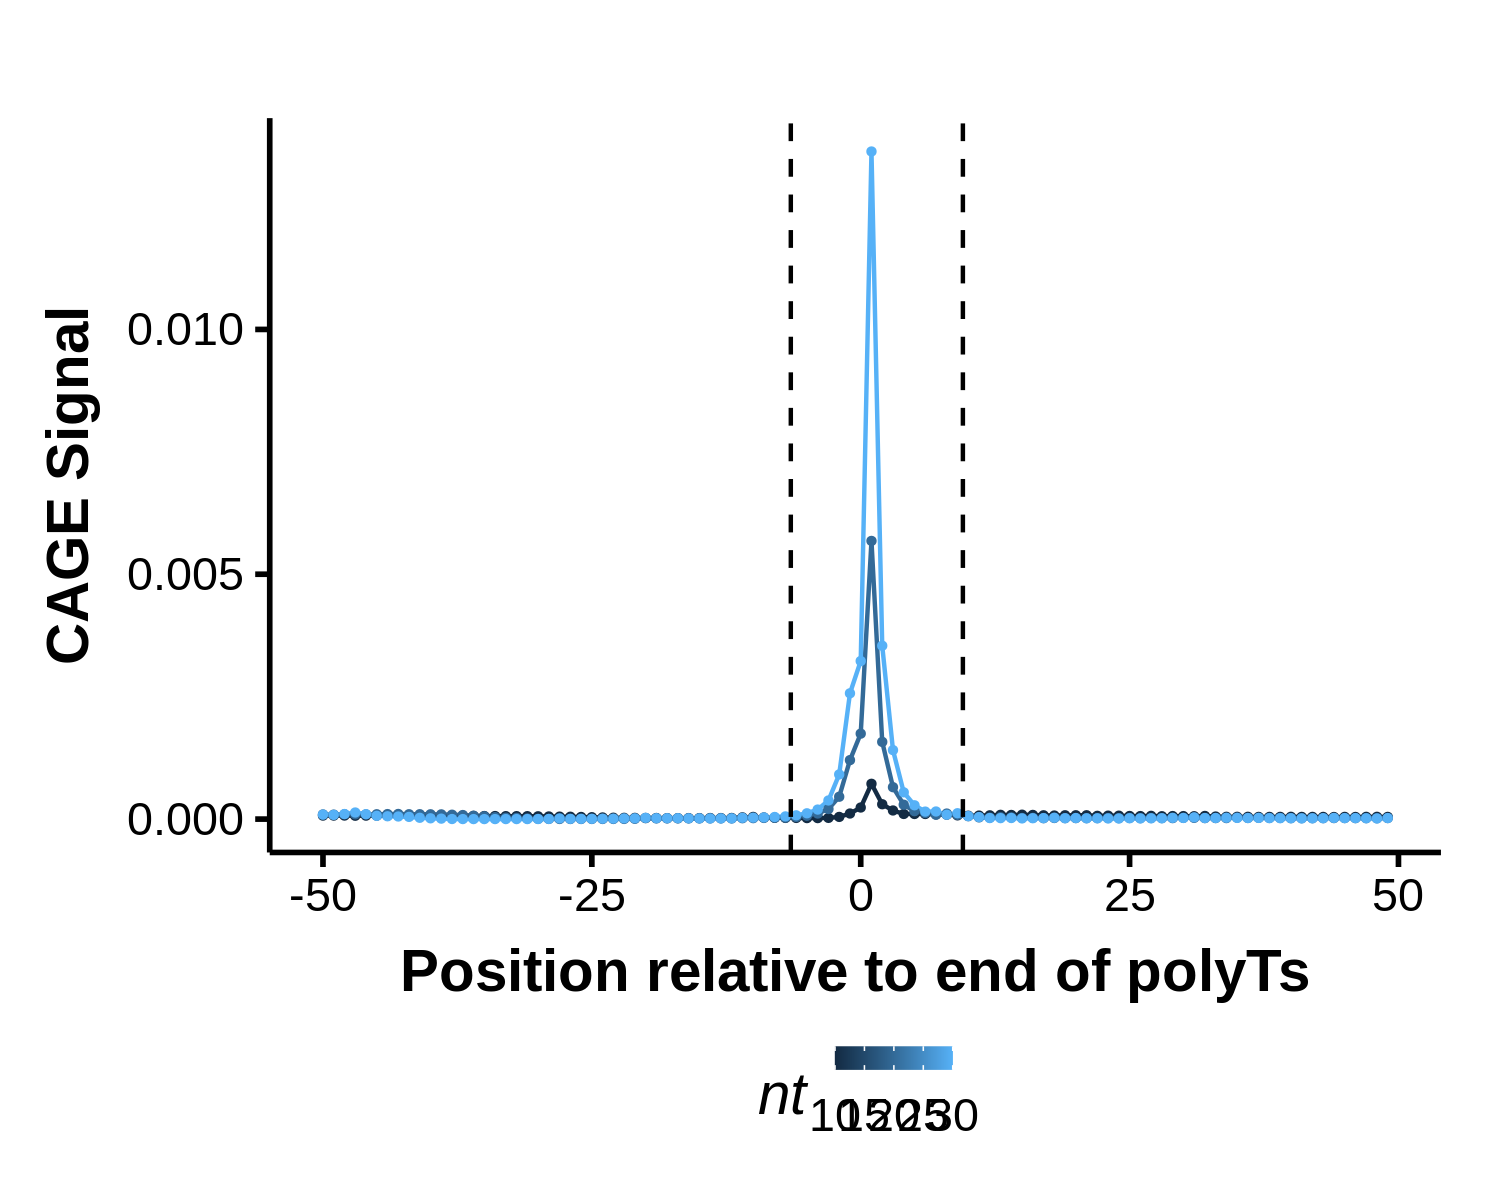

In [ ]:
%%R -i plotdata  -w 5 -h 4 --units in -r 300
require(ggplot2)

p= ggplot(plotdata)+geom_line(aes(x=pos, y=signal, group=nt, color=nt), size=I(0.5))+
    geom_point(aes(x=pos, y=signal, group=nt, color=nt), size=I(0.5))+ ylab('CAGE Signal')+ xlab('Position relative to end of polyTs')+
    theme_Publication()+geom_vline(xintercept=(-6.5), linetype=2)+geom_vline(xintercept=(9.5), linetype=2)
ggsave('../figures/filtert.pos.pdf', device=cairo_pdf)
p